## Benchmark Black Litterman

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

Stock data for each ticker is first retrieved for the 10-year date range. This is downloaded via Yahoo Finance (Python library: yfinance).

Tickers (also known as 'symbols') are used as an identifier for a given stock. A breakdown of ticker and it's respective stock is as follows:

<li>'TSLA' == Tesla
<li>'NVDA' == Nvdia
<li>'AMZN' == Amazon
<li>'META' == Meta
<li>'RIVN' == Rivian Automotive Inc??
<li>'INTC' == Intel Corp
<li>'AMD' == Advanced Micro-Devices<br>

Closing prices ('Adj Close') and logarithmic returns are then calculated. The 10 most recent closing prices for each ticker are printed using tail(10).

In [1]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)

closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    """
    Retrieves market prices and market capitalisations for a list of stock tickers. 
    Market prices are retrieved from the Vanguard S&P 500 index (VOO) based on the 
    Adjusted Close column, and market capitalisations are retrieved for each stock.

    Parameters:

    tickers: list of str
        List of stock tickers to retrieve market caps for.
    start_date: str in date format
        Start date for period to retrieve market prices.
    end_date: str in date format
        End date for period to retrieve market prices.

    market_prices: pd.Series
        Pandas Series of market prices for the VOO index.
    market_caps: dict
        Dictionary of tickers (keys) and market capitalisation (values). If a market cap 
        cannot be retrieved, set the value to 'None'.
    """
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

closing_prices.tail(10)

NameError: name 'yf' is not defined

The covariance matrix of asset returns is calculated, from which the covariance and correlation plots are displayed. Both plots are derived from the same data, however the latter provides better visualisation of asset covariances.

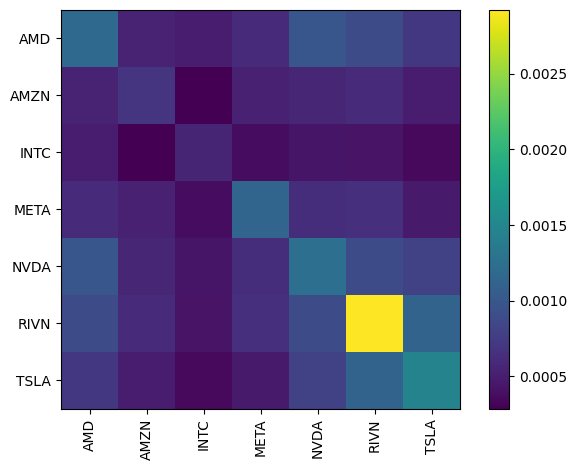

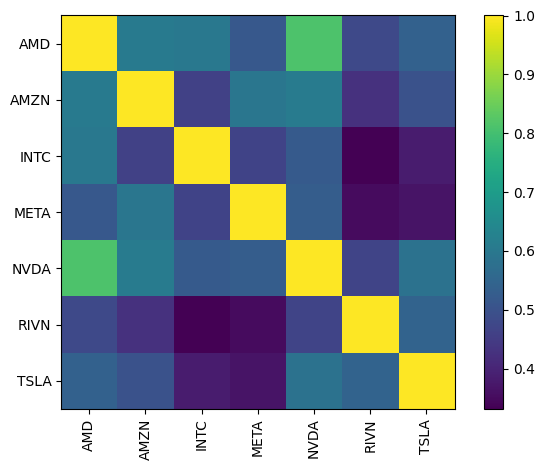

In [ ]:
covariance_matrix = returns.cov()

covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

The dataframe for the above covariance matrices can be seen below for further clarity of how returns correlate between assets.

In [ ]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

Using the previously defined function, market prices from the Vanguard S&P 500 index and market capitalisations for each ticker can be retrieved. These are used to calculate the 'Prior' and 'Delta'.

<li>Delta represents the risk-aversion co-efficient, and is used to scale the equilibrium returns. This determines the risk aversion of the investor.
<li>Prior is used to calculate the equilibrium returns based on the market portfolio (VOO). This is the benchmark portfolio which will be skewed once investor views are provided in the following section.

In [7]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

prior

[*********************100%***********************]  1 of 1 completed


Ticker
AMD     0.022603
AMZN    0.022031
INTC    0.021297
META    0.022379
NVDA    0.022978
RIVN    0.022781
TSLA    0.022588
dtype: float64

### Define Investor Views

This is the section that inherently defines the Black Litterman model, and separates it from other allocation techniques. The investor has the chance to define 'views' about the expected returns of an asset. This is typically an arbitrary value, which is addressed in subsequent model variants. The views defined here are relative, which warrants a picking matrix to map each view to the ticker and its outperforming/underperforming counterpart.

The picking matrix has four rows (each representing a single view), and seven columns (representing the ticker's position in the ticker list). A '1' represents the outperforming ticker, whereas a '-1' represents the underperforming ticker. Each row much subsequently sum to 0 (required for relative views). Based on this matrix, the following views can be extracted:

<ol>
<li>TSLA will outperform AMZN by 20%
<li>NVDA will outperform META by 15%
<li>META will outperform AMD by 10%
<li>INTC will underperform against AMD by -0.7%
</ol>

View confidences are then defined as a list, with each confidence corresponding to a given view. These are set as equal values, to allow room for a more nuanced method to be implemented in subsequent model variants.

In [8]:
relative_views = np.array([0.20, 0.15, 0.10, -0.07]).reshape(-1, 1)

confidences = [0.2, 0.2, 0.2, 0.2]

picking_matrix = np.array([
    [1, 0, -1, 0, 0, 0, 0],  # TSLA > AMZN
    [0, 1, 0, -1, 0, 0, 0],  # NVDA > META
    [0, 0, 0, 1, 0, 0, -1],  # META > AMD
    [0, 0, 0, 0, 0, -1, 1]   # INTC < AMD
])

### Run Black Litterman Model

The Black Litterman model is then called with all previous values, including the covariance matrix, prior, relative views, picking matrix, omega, view confidences, tau, and delta.

To show that absolute views have not been used for the model, this has been explicitly set to 'None'. For the omega, Idzorek's method is employed (this is what requires the picking matrix to be defined). In the case that the number of views matches the number of tickers, a picking matrix wouldn't be necessary, as this would have an implicit mapping.

In [9]:
bl = BlackLittermanModel(
    cov_matrix=covariance_matrix, 
    pi=prior, 
    absolute_views=None, 
    Q=relative_views, 
    P=picking_matrix, 
    omega="idzorek", 
    view_confidences=confidences, 
    tau=0.025, 
    risk_aversion=delta
)

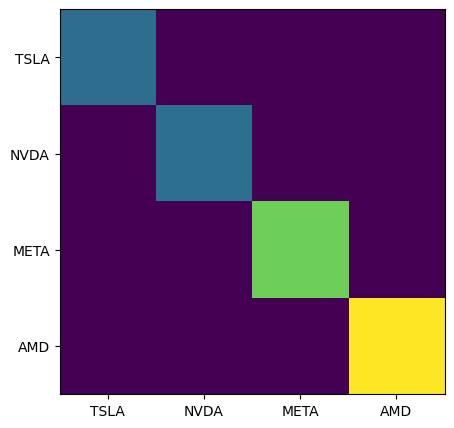

In [ ]:
def plot_omega():
    """
    Plots the Black Litterman omega value (view uncertainties)
    for all tickers where a view has been defined.
    """
    
    # Only plot for tickers where views have been defined
    tickers_with_views = ["TSLA", "NVDA", "META", "AMD"]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(bl.omega)

    ax.set_xticks(np.arange(len(tickers_with_views)))
    ax.set_yticks(np.arange(len(tickers_with_views)))

    ax.set_xticklabels(tickers_with_views)
    ax.set_yticklabels(tickers_with_views)
    plt.show()

    np.diag(bl.omega)

plot_omega()

### Calculate Posterior Returns

Posterior returns are then calculated based on the Black Litterman model which produces a posterior estimate of the returns vector.

In [2]:
bl_returns = bl.bl_returns()
bl_returns

NameError: name 'bl' is not defined

The returns are difficult to visualise on their own, so these are added to a Pandas series alongside the Prior (market implied) and the views determined by the investor so the correlation between the values can be understood.

In [ ]:
relative_views_series = pd.Series(np.nan, index=tickers)
relative_views_series[:len(relative_views)] = relative_views.flatten()

returns_df = pd.DataFrame([prior, bl_returns, relative_views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.022603,0.055642,NaN
AMZN,0.022031,0.043059,0.10
INTC,0.021297,0.014679,NaN
META,0.022379,0.020307,-0.07
NVDA,0.022978,0.047076,0.15
RIVN,0.022781,0.047748,NaN
TSLA,0.022588,0.024949,0.20


<Axes: >

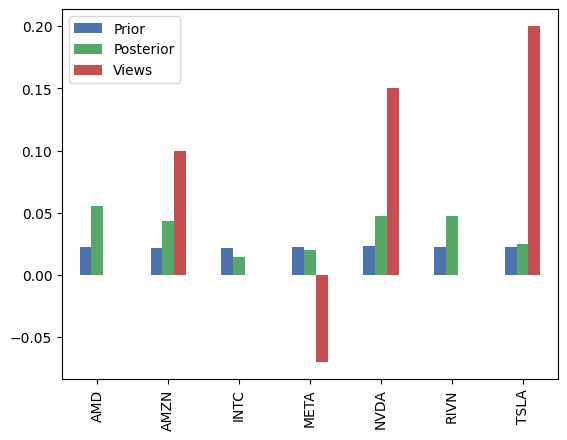

In [ ]:
# For better understanding of the above series
# the correlation between the three values are plotted on a bar graph
returns_df.plot.bar()

<Axes: >

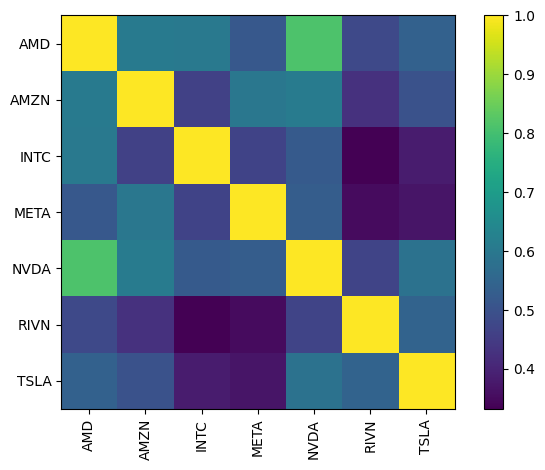

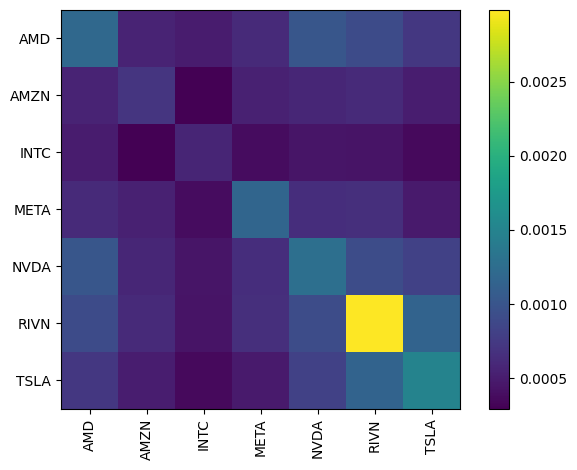

In [ ]:
# Calculation of the new posterior covariance matrix
posterior_cov = bl.bl_cov()

# Alongside the plotted matrices
# for the correlation and covariance visualisations
plotting.plot_covariance(posterior_cov, plot_correlation=True)
plotting.plot_covariance(posterior_cov, plot_correlation=False)

### Efficient Frontier Weights

The following section is used to generate the allocation weights based on the Black Litterman returns and posterior covariance matrix. The weights are optimised for both Minimum Variance and Max Sharpe portfolios, which can be used as per the investor's risk tolerance and personal strategy.

The allocations per optimised weights are visualised further down to give a better understanding of how each strategy allocates the given assets.

#### Minimum Volatility

In [ ]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_1 = EfficientFrontier(bl_returns, posterior_cov)

# Retrieve the Minimum Volatilty portfolio weights
min_vol_weights = ef_1.min_volatility()

# Cleaned weights to ensure they are rounded and sum to 1
cleaned_weights_min_vol = ef_1.clean_weights()

cleaned_weights_min_vol

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.37603),
             ('INTC', 0.57276),
             ('META', 0.01452),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.03669)])

#### Max Sharpe

In [ ]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_2 = EfficientFrontier(bl_returns, posterior_cov)

# Retrieve the Max Sharpe portfolio weights
max_sharpe_weights = ef_2.max_sharpe()

# Clean the weights to ensure they are rounded and sum to 1
cleaned_weights_max_sharpe = ef_2.clean_weights()

cleaned_weights_max_sharpe

OrderedDict([('AMD', 0.60657),
             ('AMZN', 0.39343),
             ('INTC', 0.0),
             ('META', 0.0),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

### Plot Asset Allocation Pies

In [1]:
# Set the subplots for both pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Minimum Volaility allocation
pd.Series(cleaned_weights_min_vol).plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Miniumum Volatility Allocation"
)

# Plot Max Sharpe allocation
pd.Series(cleaned_weights_max_sharpe).plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Max Sharpe Allocation"
)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

### Portfolio Performance

The above allocations are effectively meaningless without an understanding of the annualised performance and risk-adjusted performance. The following section follows the same pattern of optimising for both Min Volatility portfolio and a Max Sharpe portfolio, and utilises the PyPortfolioOpt 'portfolio_performance' function to gauge the portfolio performance for each optimisation.

To breakdown the performance metrics:
- Expected annual return: The expected returns based on the given allocation
- Annual volatility: Used to gauge how risky the allocation is. A more diverse allocation can typically expect to have a lower volatility since the risk is distributed. For the default assets used in this notebook, since they are all in the tech sector, they are more likely to have a higher volatility.
- Sharpe ratio: Used to measure the returns per unit of risk. A higher ratio is better, where anything above 3 is typically considered very good.

#### Minimum Volatility Performance

In [18]:
ef_1.portfolio_performance(verbose=True)

Expected annual return: 2.6%
Annual volatility: 2.1%
Sharpe Ratio: 0.27


(0.025809001372683698, 0.0214297325273547, 0.2710720427923495)

#### Max Sharpe Performance

In [19]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: 5.1%
Annual volatility: 2.9%
Sharpe Ratio: 1.07


(0.05069121141731352, 0.028641906700498758, 1.071549172275569)

### Get Discrete Allocation (DA)

The discrete allocation is retrieved for both the Min Volatility and Max Sharpe portfolios based on a £10,000 portfolio. This allows you to determine the number of shares to buy for each stock, which is helpful to use for a loose translation for a real world portfolio. This is not to be confused with a continuous allocation, which instead allows the investor to purchase fractional (partial) shares.

#### Minimum Volatility DA

In [ ]:
latest_prices = get_latest_prices(closing_prices)
da_min_vol = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_min_vol.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 2.16
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.380, desired 0.376
INTC: allocated 0.570, desired 0.573
META: allocated 0.000, desired 0.015
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.050, desired 0.037
Allocation has RMSE: 0.008
{'AMZN': 25, 'INTC': 115, 'TSLA': 2}


#### Max Sharpe DA

In [ ]:
latest_prices = get_latest_prices(closing_prices)
da_max_sharpe = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_max_sharpe.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 5.75
AMD: allocated 0.605, desired 0.607
AMZN: allocated 0.395, desired 0.393
INTC: allocated 0.000, desired 0.000
META: allocated 0.000, desired 0.000
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.001
{'AMD': 41, 'AMZN': 26}
